In [1]:
import os
import glob
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import deque

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
#############################################
# 1. 유틸리티 함수들
#############################################

# 1. dP 정규화 함수
def get_normalized_dP(domain_num):
    if 1 <= domain_num <= 2000:
        orig_dP = 0.005
    elif 2001 <= domain_num <= 4000:
        orig_dP = 0.0025
    elif 4001 <= domain_num <= 6000:
        orig_dP = 0.001
    else:
        raise ValueError("domain_num out of range")
    return (orig_dP - 0.001) / (0.005 - 0.001)

# 2. Signed Distance Field (SDF)
def create_signed_sdf(grid):
    rows, cols = grid.shape
    seeds = []
    dirs = [(-1,0),(1,0),(0,-1),(0,1)]
    for i in range(rows):
        for j in range(cols):
            for di, dj in dirs:
                ni, nj = i+di, j+dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    if grid[ni, nj] != grid[i, j]:
                        seeds.append((i, j))
                        break
    dist = np.full((rows, cols), -1, dtype=np.int32)
    q = deque()
    for (i, j) in seeds:
        dist[i, j] = 0
        q.append((i, j))
    while q:
        i, j = q.popleft()
        for di, dj in dirs:
            ni, nj = i+di, j+dj
            if 0 <= ni < rows and 0 <= nj < cols and dist[ni, nj] == -1:
                dist[ni, nj] = dist[i, j] + 1
                q.append((ni, nj))
    sign = np.where(grid == 0, 1.0, -1.0)
    sdf = (dist.astype(np.float32) + 0.5) * sign
    return sdf# 1. dP 정규화 함수
def get_normalized_dP(domain_num):
    if 1 <= domain_num <= 2000:
        orig_dP = 0.005
    elif 2001 <= domain_num <= 4000:
        orig_dP = 0.0025
    elif 4001 <= domain_num <= 6000:
        orig_dP = 0.001
    else:
        raise ValueError("domain_num out of range")
    return (orig_dP - 0.001) / (0.005 - 0.001)

# 2. Signed Distance Field (SDF)
def create_signed_sdf(grid):
    rows, cols = grid.shape
    seeds = []
    dirs = [(-1,0),(1,0),(0,-1),(0,1)]
    for i in range(rows):
        for j in range(cols):
            for di, dj in dirs:
                ni, nj = i+di, j+dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    if grid[ni, nj] != grid[i, j]:
                        seeds.append((i, j))
                        break
    dist = np.full((rows, cols), -1, dtype=np.int32)
    q = deque()
    for (i, j) in seeds:
        dist[i, j] = 0
        q.append((i, j))
    while q:
        i, j = q.popleft()
        for di, dj in dirs:
            ni, nj = i+di, j+dj
            if 0 <= ni < rows and 0 <= nj < cols and dist[ni, nj] == -1:
                dist[ni, nj] = dist[i, j] + 1
                q.append((ni, nj))
    sign = np.where(grid == 0, 1.0, -1.0)
    sdf = (dist.astype(np.float32) + 0.5) * sign
    return sdf

In [3]:
#############################################
# 2. 데이터 로드 및 전처리 함수들
#############################################

def load_velocity_data(npz_dir, nx=64, ny=148):
    """
    npz_dir에 있는 v*.npz 파일을 모두 불러서
    각 도메인별로 dict를 만듦
    key: 'vel' (velocity), 'mask' (이진화), 'domain_num', 'dP'
    """
    v_files = sorted(glob.glob(os.path.join(npz_dir, "v*.npz")),
                     key=lambda x: int(re.search(r"v(\d+)\.npz", os.path.basename(x)).group(1)))
    data_list = []
    for v_file in v_files:
        m_obj = re.search(r"v(\d+)\.npz", os.path.basename(v_file))
        if m_obj is None:
            continue
        domain_num = int(m_obj.group(1))
        m_file = os.path.join(npz_dir, f"m{domain_num}.npz")
        if not os.path.exists(m_file):
            continue
        with np.load(v_file) as v_npz:
            # velocity 불러오기
            if 'vel' in v_npz:
                vel = v_npz['vel']      # shape (64,148,2) or flat
                if vel.ndim == 1:  # flatten된 경우
                    n_elements = nx * ny
                    x_data = vel[:n_elements].reshape((nx, ny))
                    y_data = vel[n_elements:].reshape((nx, ny))
                    vel = np.stack([x_data, y_data], axis=-1)
            else:
                raise ValueError(f"Key 'vel' not in {v_file}")
        with np.load(m_file) as m_npz:
            if 'mask' in m_npz:
                mask = m_npz['mask']
                if mask.ndim == 1:
                    mask = mask.reshape((nx, ny))
                elif mask.ndim == 3:
                    mask = mask[0]
                mask = (mask > 0.5).astype(int)  # 2진화
            else:
                raise ValueError(f"Key 'mask' not in {m_file}")
        dP = get_normalized_dP(domain_num)
        data_list.append({'vel': vel, 'mask': mask, 'domain_num': domain_num, 'dP': dP})
    return data_list

def process_velocity_domain(sample, nx=64, ny=148):
    domain_num = sample['domain_num']
    # 1. Branch1: mask
    branch1_input = sample['mask'].reshape((1, nx, ny))
    # 2. Branch2: dP (정규화된 값)
    branch2_input = np.array([[sample['dP']]], dtype=np.float32)  # shape [1,1]
    # 3. SDF + 정규화
    sdf = create_signed_sdf(sample['mask'])
    sdf_flat = sdf.flatten().astype(np.float32)
    sdf_min, sdf_max = sdf_flat.min(), sdf_flat.max()
    sdf_norm = (sdf_flat - sdf_min) / (sdf_max - sdf_min + 1e-8)  # [0,1] 정규화

    # 4. Trunk input [x, y, SDF]
    x_coords = np.arange(nx, dtype=np.float32)
    y_coords = np.arange(ny, dtype=np.float32)
    X, Y = np.meshgrid(x_coords, y_coords, indexing="ij")
    x_flat = X.flatten()
    y_flat = Y.flatten()
    trunk_query = np.stack([x_flat, y_flat, sdf_norm], axis=1)   # (L,3)
    trunk_inputs = trunk_query[np.newaxis, ...]                  # (1, L, 3)

    # 5. Target: velocity field 정규화
    vel = sample['vel'].astype(np.float32)
    u_x, u_y = vel[..., 0], vel[..., 1]
    u_x_min, u_x_max = u_x.min(), u_x.max()
    u_y_min, u_y_max = u_y.min(), u_y.max()
    epsilon = 1e-8
    target_norm = np.empty_like(vel)
    target_norm[..., 0] = (u_x - u_x_min) / (u_x_max - u_x_min + epsilon)
    target_norm[..., 1] = (u_y - u_y_min) / (u_y_max - u_y_min + epsilon)

    # 6. norm_params: SDF min/max, velocity min/max
    norm_params = {
        'u_x_min': u_x_min, 'u_x_max': u_x_max,
        'u_y_min': u_y_min, 'u_y_max': u_y_max,
        'sdf_min': sdf_min, 'sdf_max': sdf_max
    }

    return domain_num, branch1_input, branch2_input, trunk_inputs, target_norm, norm_params


def build_velocity_dataset(domain_list, nx=64, ny=148):
    branch1_list, branch2_list, trunk_list, target_list, norm_params_list = [], [], [], [], []
    for d in domain_list:
        _, b1, b2, t, y, p = process_velocity_domain(d, nx, ny)
        branch1_list.append(b1)
        branch2_list.append(b2)
        trunk_list.append(t)
        target_list.append(y)
        norm_params_list.append(p)
    return branch1_list, branch2_list, trunk_list, target_list, norm_params_list

In [4]:
npz_dir = "/home/yehoon/npz/amv/delta_P/delta_P_data"
all_domains = load_velocity_data(npz_dir)

# dP별 그룹 분리
group1 = [d for d in all_domains if 1 <= d['domain_num'] <= 2000]
group2 = [d for d in all_domains if 2001 <= d['domain_num'] <= 4000]
group3 = [d for d in all_domains if 4001 <= d['domain_num'] <= 6000]

def split_group(group, train_ratio=0.9):
    n = len(group)
    n_train = int(n * train_ratio)
    indices = np.random.permutation(n)
    train_idx, test_idx = indices[:n_train], indices[n_train:]
    train = [group[i] for i in train_idx]
    test  = [group[i] for i in test_idx]
    return train, test

# 각 그룹별로 나누기 (seed 고정 권장)
np.random.seed(42)
train_g1, test_g1 = split_group(group1, train_ratio=0.9)
train_g2, test_g2 = split_group(group2, train_ratio=0.9)
train_g3, test_g3 = split_group(group3, train_ratio=0.9)

# 합치기
train_domains = train_g1 + train_g2 + train_g3
test_domains  = test_g1  + test_g2  + test_g3

# 이후는 그대로...
train_b1, train_b2, train_t, train_y, train_p = build_velocity_dataset(train_domains)
test_b1, test_b2, test_t, test_y, test_p = build_velocity_dataset(test_domains)

train_branch1 = torch.tensor(np.stack(train_b1), dtype=torch.float32)
train_branch2 = torch.tensor(np.stack(train_b2), dtype=torch.float32)
train_trunk   = torch.tensor(np.stack(train_t), dtype=torch.float32)
train_target  = torch.tensor(np.stack(train_y), dtype=torch.float32)

test_branch1  = torch.tensor(np.stack(test_b1), dtype=torch.float32)
test_branch2  = torch.tensor(np.stack(test_b2), dtype=torch.float32)
test_trunk    = torch.tensor(np.stack(test_t), dtype=torch.float32)
test_target   = torch.tensor(np.stack(test_y), dtype=torch.float32)

train_dataset = TensorDataset(train_branch1, train_branch2, train_trunk, train_target)
test_dataset  = TensorDataset(test_branch1, test_branch2, test_trunk, test_target)


In [5]:
#############################################
# 4. 수정된 모델 구성 – VelocityDeepONet
#############################################

class BasicCNN(nn.Module):
    def __init__(self, in_channels, out_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 16, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.SiLU(), nn.AvgPool2d(2)
        )
        self.fc = nn.Linear(64 * 8 * 18, 2*out_dim)  # (u_x, u_y 각각 out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)  # [N, 2*out_dim]

# Branch2: dP(스칼라) → MLP → [N, 2*out_dim]
class dPMLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=80, hidden_dim=80, num_layers=3):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden_dim), nn.SiLU()]
        for _ in range(num_layers-2):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.SiLU()]
        layers += [nn.Linear(hidden_dim, 2*out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)  # [N, 2*out_dim]

# Trunk: (x, y, SDF) → MLP → [N, L, 2, out_dim]
def create_trunk_net(trunk_in_dim, out_dim, num_layers=6, width=80):
    layers = [nn.Linear(trunk_in_dim, width), nn.SiLU()]
    for _ in range(num_layers-2):
        layers += [nn.Linear(width, width), nn.SiLU()]
    layers += [nn.Linear(width, 2*out_dim)]  # (u_x, u_y 각각 out_dim)
    return nn.Sequential(*layers)

# dP 조건부 VelocityDeepONet
class VelocityDeepONetDP(nn.Module):
    def __init__(self, branch1_in_dim=1, branch2_in_dim=1, trunk_in_dim=3,
                 out_dim=100, num_layers=6, width=80, nx=64, ny=148):
        super().__init__()
        self.branch1_net = BasicCNN(branch1_in_dim, out_dim)
        self.branch2_net = dPMLP(branch2_in_dim, out_dim, hidden_dim=width, num_layers=3)
        self.trunk_net = create_trunk_net(trunk_in_dim, out_dim, num_layers, width)
        self.bias = nn.Parameter(torch.zeros(2))
        self.nx, self.ny = nx, ny
        self.out_dim = out_dim

    def forward(self, branch1_input, branch2_input, trunk_input):
        N, T, L, D = trunk_input.shape
        trunk_flat = trunk_input.view(-1, D)
        trunk_out = self.trunk_net(trunk_flat)
        trunk_out = trunk_out.view(N, T, L, 2, self.out_dim)
    
        branch1_out = self.branch1_net(branch1_input)   # (N, 2*out_dim)
        branch2_out = self.branch2_net(branch2_input)   # (N, 2*out_dim)여야 한다!

        if branch2_out.dim() > 2:
            branch2_out = branch2_out.squeeze(1)

        branch_out = branch1_out * branch2_out          # (N, 2*out_dim)
        branch_out = branch_out.view(N, 2, self.out_dim)
        branch_out = branch_out.unsqueeze(1).unsqueeze(2)  # (N,1,1,2,out_dim)
    
        out = torch.sum(branch_out * trunk_out, dim=-1) + self.bias
        out = out.view(N, self.nx, self.ny, 2)
        return out
    

In [6]:
#############################################
# 5. 학습 및 평가 함수
#############################################

def train_model(model, train_dataset, test_dataset, num_epochs=100, lr=0.001, batch_size=25, patience=15):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.HuberLoss(delta=1.0)
    scaler = torch.cuda.amp.GradScaler()

    class EarlyStopping:
        def __init__(self, patience=10, delta=1e-5, verbose=False):
            self.patience = patience
            self.delta = delta
            self.verbose = verbose
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
            self.best_model_state = None
        def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.delta:
                self.best_loss = val_loss
                self.counter = 0
                self.best_model_state = model.state_dict()
                if self.verbose:
                    print(f"Validation loss decreased. New best loss: {val_loss:.6f}")
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True

    early_stopping = EarlyStopping(patience=patience, delta=1e-5, verbose=True)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # --- training ---
        model.train()
        running_train_loss = 0.0
        for b1, b2, t, y in train_loader:
            b1, b2, t, y = b1.cuda(), b2.cuda(), t.cuda(), y.cuda()
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                preds = model(b1, b2, t)
                loss = criterion(preds, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # --- validation ---
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for b1, b2, t, y in test_loader:
                b1, b2, t, y = b1.cuda(), b2.cuda(), t.cuda(), y.cuda()
                with torch.cuda.amp.autocast():
                    preds = model(b1, b2, t)
                    loss = criterion(preds, y)
                running_test_loss += loss.item()
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

        early_stopping(avg_test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model state.")
            model.load_state_dict(early_stopping.best_model_state)
            break

    return train_losses, test_losses

In [7]:
model = VelocityDeepONetDP(
    branch1_in_dim=1,
    branch2_in_dim=1,
    trunk_in_dim=3,
    out_dim=500,
    num_layers=8,
    width=500,
    nx=64,
    ny=148
)

# 2. 학습
train_losses, test_losses = train_model(
    model, train_dataset, test_dataset, num_epochs=500, lr=0.001, batch_size=25, patience=15
)

/tmp/ipykernel_1117109/2007051620.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_1117109/2007051620.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1117109/2007051620.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/500] Train Loss: 0.014764, Test Loss: 0.010798
Validation loss decreased. New best loss: 0.010798
Epoch [2/500] Train Loss: 0.011026, Test Loss: 0.010569
Validation loss decreased. New best loss: 0.010569
Epoch [3/500] Train Loss: 0.010676, Test Loss: 0.010743
No improvement: 1/15
Epoch [4/500] Train Loss: 0.010328, Test Loss: 0.010998
No improvement: 2/15
Epoch [5/500] Train Loss: 0.010058, Test Loss: 0.010040
Validation loss decreased. New best loss: 0.010040
Epoch [6/500] Train Loss: 0.009919, Test Loss: 0.009958
Validation loss decreased. New best loss: 0.009958
Epoch [7/500] Train Loss: 0.009749, Test Loss: 0.010245
No improvement: 1/15
Epoch [8/500] Train Loss: 0.009401, Test Loss: 0.009427
Validation loss decreased. New best loss: 0.009427
Epoch [9/500] Train Loss: 0.009037, Test Loss: 0.009291
Validation loss decreased. New best loss: 0.009291
Epoch [10/500] Train Loss: 0.008669, Test Loss: 0.008910
Validation loss decreased. New best loss: 0.008910
Epoch [11/500] Trai

In [15]:
#############################################
# 후보정 및 후보정 기반 시각화 함수들 (유속)
#############################################

def apply_candidate_correction(arr, mask):
    arr = arr.copy()
    arr[mask < 0.5] = 0
    return arr

def inverse_normalize(arr, norm_param):
    x = arr[..., 0] * (norm_param['u_x_max'] - norm_param['u_x_min']) + norm_param['u_x_min']
    y = arr[..., 1] * (norm_param['u_y_max'] - norm_param['u_y_min']) + norm_param['u_y_min']
    return np.stack([x, y], axis=-1)

def inverse_normalize_sdf(normed_sdf, norm_param):
    return normed_sdf * (norm_param['sdf_max'] - norm_param['sdf_min']) + norm_param['sdf_min']

# 8. 예측/시각화 샘플
def visualize_velocity_field(model, branch1_tensor, branch2_tensor, trunk_tensor, target_tensor, norm_params, sample_idx):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        b1 = branch1_tensor[sample_idx:sample_idx+1].to(device)
        b2 = branch2_tensor[sample_idx:sample_idx+1].to(device)
        t = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(b1, b2, t).cpu().numpy()[0]
        actual = target_tensor[sample_idx].cpu().numpy()
    preds = inverse_normalize(preds, norm_params[sample_idx])
    actual = inverse_normalize(actual, norm_params[sample_idx])
    mask = branch1_tensor[sample_idx, 0].cpu().numpy()
    p_corr = apply_candidate_correction(preds, mask)
    a_corr = apply_candidate_correction(actual, mask)
    ux_sim, ux_pred = a_corr[..., 0], p_corr[..., 0]
    uy_sim, uy_pred = a_corr[..., 1], p_corr[..., 1]
    vmin_x, vmax_x = ux_sim.min(), ux_sim.max()
    vmin_y, vmax_y = uy_sim.min(), uy_sim.max()
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), constrained_layout=True)
    axes[0,0].imshow(ux_sim, vmin=vmin_x, vmax=vmax_x)
    axes[0,0].set_title('Simulation u_x')
    im = axes[0,1].imshow(ux_pred, vmin=vmin_x, vmax=vmax_x)
    axes[0,1].set_title('Predicted u_x')
    fig.colorbar(im, ax=axes[0,:], orientation='vertical')
    axes[1,0].imshow(uy_sim, vmin=vmin_y, vmax=vmax_y)
    axes[1,0].set_title('Simulation u_y')
    im2 = axes[1,1].imshow(uy_pred, vmin=vmin_y, vmax=vmax_y)
    axes[1,1].set_title('Predicted u_y')
    fig.colorbar(im2, ax=axes[1,:], orientation='vertical')
    plt.show()


def compute_errors(model, branch_tensor, trunk_tensor, target_tensor, norm_params, sample_idx):
    """
    예측 및 실제를 가져와 후보정 및 역정규화 후
    - percent_error_u/v
    - abs_error_u/v
    반환
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        b = branch_tensor[sample_idx:sample_idx+1].to(device)
        t = trunk_tensor[sample_idx:sample_idx+1].to(device)
        pred = model(b, t).cpu().numpy()[0]
        actual = target_tensor[sample_idx].numpy()

    pred = inverse_normalize(pred, norm_params)
    actual = inverse_normalize(actual, norm_params)
    mask = branch_tensor[sample_idx,0].numpy()

    p_corr = apply_candidate_correction(pred, mask)
    a_corr = apply_candidate_correction(actual, mask)

    eps = 1e-8
    percent_u = ((p_corr[...,0] - a_corr[...,0]) / (np.abs(a_corr[...,0])+eps) * 100).clip(-10,10)
    percent_v = ((p_corr[...,1] - a_corr[...,1]) / (np.abs(a_corr[...,1])+eps) * 100).clip(-10,10)
    abs_u = np.abs(p_corr[...,0] - a_corr[...,0])
    abs_v = np.abs(p_corr[...,1] - a_corr[...,1])

    return percent_u, percent_v, abs_u, abs_v

def compute_nrmse_velocity_corrected(preds, actual, mask):
    # mask: 0(암석), 1(공극)
    area = (mask > 0.5)
    if area.sum() == 0:
        return 0.0
    pred_flat = preds[area]
    actual_flat = actual[area]
    rmse = np.sqrt(np.mean((pred_flat - actual_flat) ** 2))
    denom = np.max(actual_flat) - np.min(actual_flat) + 1e-8
    nrmse = rmse / denom
    return nrmse


def evaluate_sample_velocity(model, test_branch1, test_branch2, test_trunk, test_target, idx):
    # 입력: tensor들, idx 번째 샘플
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        branch1 = test_branch1[idx:idx+1].to(device)
        branch2 = test_branch2[idx:idx+1].to(device)
        trunk   = test_trunk[idx:idx+1].to(device)
        target  = test_target[idx:idx+1].to(device)
        preds = model(branch1, branch2, trunk)   # [1, 64, 148, 2]
        preds_np = preds.cpu().numpy()[0]
        target_np = target.cpu().numpy()[0]
        return preds_np, target_np

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# 3) 시각화할 샘플 인덱스
sample_idx = 0

# 4) 2×2 필드 비교
norm_params = test_p[sample_idx]                           # 도메인마다 저장해둔 정규화 파라미터
visualize_results_velocity_corrected(
    model,
    test_branch,    # torch.Tensor, shape = (N,1,nx,ny)
    test_trunk,     # torch.Tensor, shape = (N,1,nx*ny,3)
    test_target,    # torch.Tensor, shape = (N,nx,ny,2)
    sample_idx,
    norm_params,
    save_svg="field_comparison.svg"  # 저장을 원치 않으면 이 인자 생략
)

NameError: name 'visualize_results_velocity_corrected' is not defined

In [ ]:
with torch.no_grad():
    b = test_branch[sample_idx:sample_idx+1].to(device)
    t = test_trunk[sample_idx:sample_idx+1].to(device)
    pred_field = model(b, t).cpu().numpy()[0]          # (nx,ny,2)
actual_field = test_target[sample_idx].numpy()         # (nx,ny,2)
mask = test_branch[sample_idx,0].numpy()               # (nx,ny), 0=광물

scatter_velocity_corrected(
    pred_field,
    actual_field,
    mask,
    save_svg="scatter_u.png"
)

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))

# 선 그래프를 그리고
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses,  label='Test Loss')

# 로그 스케일 설정 (y축만)
plt.yscale('log')

# (원하시면 x축도 로그 스케일로)
# plt.xscale('log')

# 축 라벨, 제목, 범례, 그리드
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Velocity (Log Scale)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# SVG로 저장
plt.savefig("velocity_loss_log.svg", format="svg")
plt.show()


In [16]:
errors = []
for idx in range(len(test_branch1)):
    preds, actual = evaluate_sample_velocity(
        model, 
        test_branch1, 
        test_branch2, 
        test_trunk, 
        test_target, 
        idx
    )
    mask = test_branch1[idx].cpu().numpy()[0]
    nrmse = compute_nrmse_velocity_corrected(preds, actual, mask)
    errors.append(nrmse)

errors = np.array(errors)
best_idx = int(np.argmin(errors))
best_domain = test_domains[best_idx]['domain_num']
best_nrmse = errors[best_idx]

print(f"가장 오차가 작은 테스트 인덱스: {best_idx}")
print(f"해당 도메인 번호         : {best_domain}")
print(f"최소 NRMSE 값           : {best_nrmse:.4f}")


가장 오차가 작은 테스트 인덱스: 136
해당 도메인 번호         : 167
최소 NRMSE 값           : 0.0154


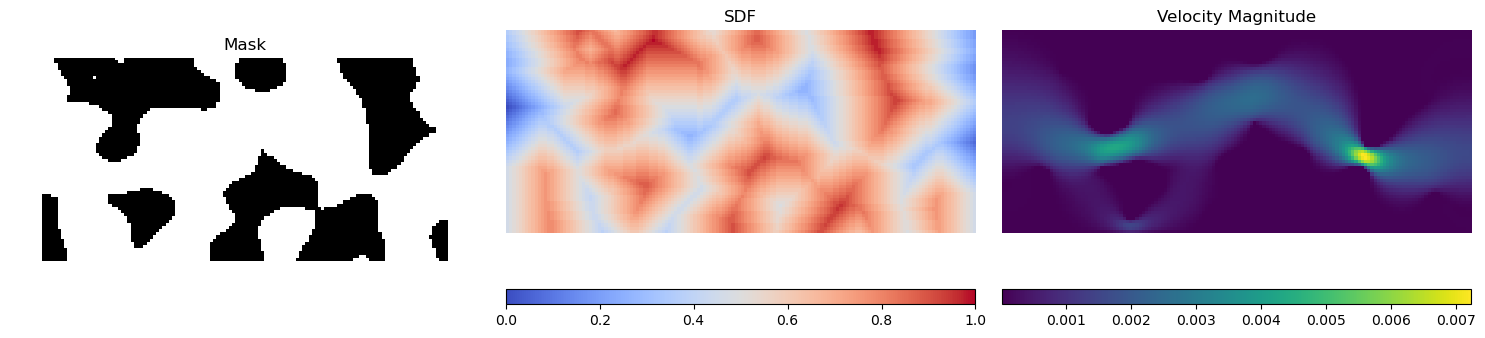

In [18]:
test_idx = 136

# 1. 마스크 이미지
mask_img = test_branch1[test_idx, 0].cpu().numpy()    # (64,148)

# 2. SDF 이미지
sdf_flat = test_trunk[test_idx, 0, :, 2].cpu().numpy()
sdf_img = sdf_flat.reshape(mask_img.shape)

# 3. 유속 벡터 (정규화 해제)
norm_p = test_p[test_idx]
u_x_min, u_x_max = norm_p['u_x_min'], norm_p['u_x_max']
u_y_min, u_y_max = norm_p['u_y_min'], norm_p['u_y_max']

vel_norm = test_target[test_idx].cpu().numpy()   # (64,148,2)
u_x = vel_norm[..., 0] * (u_x_max - u_x_min) + u_x_min
u_y = vel_norm[..., 1] * (u_y_max - u_y_min) + u_y_min
vel_vec = np.stack([u_x, u_y], axis=-1)         # (64,148,2)
vel_mag = np.linalg.norm(vel_vec, axis=-1)      # (64,148)

# --- 시각화 ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(mask_img, cmap='gray')
axes[0].set_title("Mask")
axes[0].axis('off')

im1 = axes[1].imshow(sdf_img, cmap='coolwarm')
axes[1].set_title("SDF")
axes[1].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[1], orientation='horizontal', shrink=1, pad=0.15, aspect=30)

im2 = axes[2].imshow(vel_mag, cmap='viridis')
axes[2].set_title("Velocity Magnitude")
axes[2].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[2], orientation='horizontal', shrink=1, pad=0.15, aspect=30)

plt.tight_layout()
plt.savefig("DON_v_dP.svg", format="svg")
plt.show()


In [ ]:
print(sdf_flat.shape)
print("최소값:", sdf_flat.min())
print("최대값:", sdf_flat.max())
print("평균:", sdf_flat.mean())
print("중간값:", np.median(sdf_flat))
print("앞부분 10개:", sdf_flat[:10])

print("0(암석) 개수:", np.sum(mask_img==0))
print("1(공극) 개수:", np.sum(mask_img==1))
print("mask_img 고유값:", np.unique(mask_img))


In [ ]:
# --- 1) NRMSE 계산 및 분위수 샘플 추출 ---
nrmse_list = []
num_samples = len(test_branch)
for idx in range(num_samples):
    preds_norm, actual_norm = evaluate_sample_velocity(
        model,
        test_branch,
        test_trunk,
        test_target,
        idx
    )
    mask = test_branch[idx].cpu().numpy()[0]
    nrmse_list.append(compute_nrmse_velocity_corrected(preds_norm, actual_norm, mask))
nrmse_arr = np.array(nrmse_list)

best_idx  = nrmse_arr.argmin()
worst_idx = nrmse_arr.argmax()
sorted_idx = np.argsort(nrmse_arr)
idx25 = sorted_idx[int(0.25 * len(sorted_idx))]
idx50 = sorted_idx[int(0.50 * len(sorted_idx))]
idx75 = sorted_idx[int(0.75 * len(sorted_idx))]
sample_indices = [best_idx, idx25, idx50, idx75, worst_idx]
row_labels     = ["Best", "25%", "50%", "75%", "Worst"]

# --- 2) 전역 vmin/vmax 계산 (예측/실제 벡터장의 크기, 오차) ---
mag_vals, err_vals = [], []
for idx in sample_indices:
    preds_norm, actual_norm = evaluate_sample_velocity(
        model, test_branch, test_trunk, test_target, idx
    )
    preds_denorm  = inverse_normalize(preds_norm,  test_p[idx])
    actual_denorm = inverse_normalize(actual_norm, test_p[idx])
    mask = test_branch[idx].cpu().numpy()[0]
    preds_corr  = apply_candidate_correction(preds_denorm,  mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    mag_pred = np.linalg.norm(preds_corr, axis=-1)
    mag_act  = np.linalg.norm(actual_corr, axis=-1)
    mag_vals.extend([mag_act.flatten(), mag_pred.flatten()])
    err_vals.append(np.abs(mag_pred - mag_act).flatten())

mag_all = np.concatenate(mag_vals)
err_all = np.concatenate(err_vals)
vmin_mag, vmax_mag = mag_all.min(), mag_all.max()
vmin_err, vmax_err = 0.0, err_all.max()

# --- 3) 5×3 그리드 플롯 ---
fig, axes = plt.subplots(5, 3, figsize=(12, 10))
plt.subplots_adjust(top=0.93, bottom=0.12, left=0.10, right=0.95,
                    hspace=0.3, wspace=0.15)

for row, idx in enumerate(sample_indices):
    preds_norm, actual_norm = evaluate_sample_velocity(
        model, test_branch, test_trunk, test_target, idx
    )
    preds_denorm  = inverse_normalize(preds_norm,  test_p[idx])
    actual_denorm = inverse_normalize(actual_norm, test_p[idx])
    mask = test_branch[idx].cpu().numpy()[0]
    preds_corr  = apply_candidate_correction(preds_denorm,  mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)
    mag_pred = np.linalg.norm(preds_corr, axis=-1)
    mag_act  = np.linalg.norm(actual_corr, axis=-1)
    mag_err  = np.abs(mag_pred - mag_act)

    # Column 0: Simulation |v|
    ax0 = axes[row, 0]
    im0 = ax0.imshow(mag_act, origin='lower',
                     vmin=vmin_mag, vmax=vmax_mag,
                     cmap='viridis')
    ax0.set_ylabel(row_labels[row], rotation=0, labelpad=50, va='center')
    if row == 0:
        ax0.set_title("Simulation")
    ax0.set_xticks([]); ax0.set_yticks([])

    # Column 1: DeepONet |v|
    ax1 = axes[row, 1]
    im1 = ax1.imshow(mag_pred, origin='lower',
                     vmin=vmin_mag, vmax=vmax_mag,
                     cmap='viridis')
    if row == 0:
        ax1.set_title("PRT-DeepONet")
    ax1.axis('off')

    # Column 2: Absolute Error
    ax2 = axes[row, 2]
    im2 = ax2.imshow(mag_err, origin='lower',
                     vmin=vmin_err, vmax=vmax_err,
                     cmap='viridis')
    if row == 0:
        ax2.set_title("Abs Error")
    ax2.axis('off')

# --- 4) 하단 컬러바 ---
cbar_ax1 = fig.add_axes([0.1, 0.05, 0.55, 0.01])
fig.colorbar(im0, cax=cbar_ax1, orientation='horizontal')
cbar_ax2 = fig.add_axes([0.69, 0.05, 0.26, 0.01])
fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal')

plt.savefig("vel_per.svg", format="svg")
plt.show()


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
num_samples = len(test_branch)

# 1) 유속 비율 계산
vel_ratio = []
for idx in range(num_samples):
    sb = test_branch[idx:idx+1].to(device)
    st = test_trunk[idx:idx+1].to(device)
    with torch.no_grad():
        pred_norm = model(sb, st).cpu().numpy()[0]    # (nx, ny, 2)

    actual_norm = test_target[idx].cpu().numpy()
    mask        = test_branch[idx].cpu().numpy()[0]

    pred_mag   = np.sqrt(pred_norm[...,0]**2 + pred_norm[...,1]**2)
    actual_mag = np.sqrt(actual_norm[...,0]**2 + actual_norm[...,1]**2)

    pred_corr   = apply_candidate_correction(pred_mag, mask)
    actual_corr = apply_candidate_correction(actual_mag, mask)
    mean_pred   = pred_corr.mean()
    mean_actual = actual_corr.mean()

    vel_ratio.append(mean_actual / mean_pred if mean_pred != 0 else np.nan)

# 2) 시각화
plt.figure(figsize=(8,4))
plt.scatter(np.arange(num_samples), vel_ratio, alpha=0.5)
plt.hlines(1, 0, num_samples-1, linestyles='--', color='red', label='Ratio=1')

# y축 범위 고정
plt.ylim(0.8, 1.2)

plt.xlabel("Test Sample Index")
plt.ylabel("Actual / Predicted")
plt.title("Mean Velocity Magnitude Ratio")
plt.legend()
plt.tight_layout()

# SVG로 저장
plt.savefig("velocity_ratio.svg", format="svg")

plt.show()


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
num_samples = len(test_branch)

vel_ratio = []
for idx in range(num_samples):
    sb = test_branch[idx:idx+1].to(device)
    st = test_trunk[idx:idx+1].to(device)
    with torch.no_grad():
        pred_norm = model(sb, st).cpu().numpy()[0]    # (nx, ny, 2)
    actual_norm = test_target[idx].cpu().numpy()
    mask = test_branch[idx].cpu().numpy()[0]

    pred_mag   = np.sqrt(pred_norm[...,0]**2 + pred_norm[...,1]**2)
    actual_mag = np.sqrt(actual_norm[...,0]**2 + actual_norm[...,1]**2)

    # 암석(mask==0)은 제외하고, 공극(mask==1)만 평균
    mean_pred   = pred_mag[mask == 1].mean()
    mean_actual = actual_mag[mask == 1].mean()

    vel_ratio.append(mean_pred / mean_actual if mean_pred != 0 else np.nan)

plt.figure(figsize=(8,4))
plt.scatter(np.arange(num_samples), vel_ratio, alpha=0.5)
plt.hlines(1, 0, num_samples-1, linestyles='--', color='red', label='Ratio=1')
plt.ylim(0.8, 1.2)
plt.xlabel("Test Sample Index")
plt.ylabel("Predicted / Actual")
plt.legend()
plt.tight_layout()
plt.savefig("velocity_ratio.svg", format="svg")
plt.show()
